# VGGFace 2 and Lime Full Pipeline

We need to do five things:
1. Crop faces with MTCNN
2. Extract features with VGGFace2
3. Run Classifier
4. Fit all in one pipeline
5. Run Lime

In [2]:
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## Crop Face

In [20]:
img_path = "./sample_images/Kamala_Harris.jpg"
face_path = "./sample_images/kamala_harris_cropped.jpg"

In [21]:
from crop_face import crop_faces, convert_face_tensor_to_numpy_array

face = crop_faces(img_path, keep_all=False)

In [22]:
face.shape

torch.Size([3, 160, 160])

In [23]:
img_array = convert_face_tensor_to_numpy_array(face)

Image.fromarray(img_array).save(face_path)

## Load Resnet 50 model trained on VGGFace2

In [24]:
from saved_model.prepare_resnet50 import prepare_resnet_model

resnet_model = prepare_resnet_model("./saved_model/resnet50_ft_weight.pkl")

## Load Pretrained Lasso Regression Model

In [25]:
import joblib

lasso_model = joblib.load("./saved_model/lasso.joblib")

## Putting it all together

The preprocessing for VGGFace2 is copied from the [authors' github repo](https://github.com/ox-vgg/vgg_face2/blob/master/standard_evaluation/pytorch_feature_extractor.py).

In [26]:
from data.load_image import load_image_for_feature_extraction

img, original = load_image_for_feature_extraction(face_path, shape=(224,224,3))
img_batch = np.expand_dims(img, 0)
img_batch.shape

(1, 224, 224, 3)

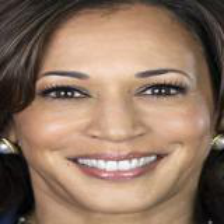

In [27]:
display(original)

In [28]:
def full_pipeline(x):
    x = torch.Tensor(x.transpose(0, 3, 1, 2))  # 1x3x224x224
    x = x.to(device)
    x = resnet_model(x).detach().cpu().numpy()
    return lasso_model.predict_proba(x)

In [29]:
labels = ["liberal", "conservative"]

def predict_face(img_arr):
    img_arr = np.expand_dims(img_arr, 0) # 1x224x224x3
    prediction_probs = full_pipeline(img_arr).squeeze(0)   
    return prediction_probs

In [30]:
prediction = predict_face(img)
print(list(zip(labels, prediction)))

[('liberal', 0.685666473756666), ('conservative', 0.31433352624333405)]


# Lime

In [31]:
from lime import lime_image

In [32]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img, full_pipeline,  hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [33]:
from skimage.segmentation import mark_boundaries

In [34]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5)

In [35]:
explanation.top_labels

[0, 1]

In [36]:
img_boundry = mark_boundaries(temp/255.0, mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


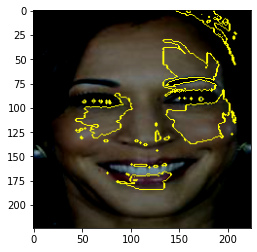

In [37]:
plt.imshow(img_boundry)